<a href="https://colab.research.google.com/github/sefeoglu/AE_Parseval_Network/blob/master/src/notebooks/ResNet_Tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New ResNet

In [0]:
import tensorflow as tf

In [0]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Input, Add, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import  l2
from tensorflow.keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0005

In [0]:
def initial_conv(input):
  x = Convolution2D(16,(3,3),padding="same", kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay),use_bias=False)(input)
  channel_axis = 1 if K.image_data_format() == "channels_first" else -1
  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  return x

In [0]:
def expand_conv(init, base, k, strides = (1,1)):
  x = Convolution2D(base * k, kernel_size=(3,3),padding= "same", strides=strides, kernel_initializer="he_normal", kernel_regularizer=l2(weight_decay),
                    use_bias=False)(init)
  channel_axis = 1 if K.image_data_format() == "channels_first" else -1

  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon= 1e-5, gamma_initializer= 'uniform')(x)
  x = Activation('relu')(x)

  x = Convolution2D(base * k, kernel_size=(3,3), padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=l2(weight_decay),
                    use_bias = False)(x)
  skip = Convolution2D(base * k, kernel_size=(1,1), padding='same', strides=strides, kernel_initializer='he_normal',
                       kernel_regularizer=l2(weight_decay),
                       use_bias = False)(init)
  m = Add()([x, skip])
  return m

In [0]:
def conv1_block(input, k=1, dropout = 0.0):
  init = input
  
  channel_axis = 1 if K.image_data_format() == "channels_first" else -1

  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
  x = Activation('relu')(x)
  x = Convolution2D(16 * k, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay),
                    use_bias=False)(x)
  if dropout > 0.0: x = Dropout(dropout)(x)

  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  x = Convolution2D(16 * k, kernel_size=(3,3), padding='same', kernel_initializer='he_normal',kernel_regularizer=l2(weight_decay),
                    use_bias = False)(x)
  m = Add()([init, x])
  return m

In [0]:
def  conv2_block(input, k=1, dropout = 0.0):
  init = input

  channel_axis = 1 

  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
  x = Activation('relu')(x)
  x = Convolution2D(32 * k, kernel_size=(3,3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer = l2(weight_decay), use_bias = False)(x)
  
  if dropout > 0.0: x = Dropout(dropout)(x)

  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  x = Convolution2D(32*k, kernel_size=(3,3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer= l2(weight_decay),
                    use_bias = False)(x)
  
  m = Add()([init, x])
  return m


In [0]:
def conv3_block(input, k=1, dropout=0.0):
  init = input

  channel_axis = 1 

  x = BatchNormalization(axis=channel_axis, momentum= 0.1, epsilon = 1e-5, gamma_initializer='uniform' )(input)
  x = Activation('relu')(x)
  x = Convolution2D(64 * k, kernel_size=(3,3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer= l2(weight_decay),
                    use_bias = False)(x)
  
  if dropout > 0.0: x = Dropout(dropout)(x)

  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  x = Convolution2D(64 * k, kernel_size=(3,3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay),
                    use_bias=False)(x)
  m = Add()([init, x])
  return m


In [0]:
def create_wide_residual_network(input_dim, nb_classes=4, N=2, k=2, dropout = 0.0, verbose=1):
  channel_axis = 1 if K.image_data_format() == "channels_first" else -1

  ip = Input(shape=input_dim)

  x = initial_conv(ip)
  nb_conv = 4
  x = expand_conv(x, 16, k)
  nb_conv +=2

  for i in range(N-1):
    x = conv1_block(x, k, dropout)
    nb_conv +=2
  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)

  x = expand_conv(x, 32, k, strides=(1, 1))
  nb_conv += 2
  for i in range(N - 1):
    x = conv2_block(x, k, dropout)
    nb_conv += 2
  
  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  
  x = expand_conv(x, 64, k, strides=(1, 1))
  nb_conv += 2
  
  for i in range(N - 1):
    x = conv3_block(x, k, dropout)
    nb_conv += 2
    
  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  
  x = AveragePooling2D((8, 8))(x)
  x = Flatten()(x)
  
  x = Dense(nb_classes, kernel_regularizer=l2(weight_decay), activation='softmax')(x)
  
  model = Model(ip, x)
  
  if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
  
  return model





In [20]:
if __name__ == "__main__":
    from tensorflow.keras.utils import plot_model
    from tensorflow.keras.layers import Input
    from tensorflow.keras.models import Model

    init = (68, 100,1)
    wrn28_10 = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout = 0.0, verbose=1)
  

Wide Residual Network-16-2 created.


In [0]:
from sklearn.model_selection import train_test_split
import gzip
import pickle
import numpy as np

In [22]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(row['crop'])
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 68, 100)

In [0]:
X_train, y_train = new_data_X, Y_data

In [0]:
X_train = X_train.astype('float32')

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# creating initial dataframe
y_train_df = pd.DataFrame(y_train, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_train_df['New'] = labelencoder.fit_transform(y_train_df['Label'])

In [0]:

img_rows, img_cols = X_train[0].shape

# transform data set
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    input_shape = (1, img_rows, img_cols)

In [0]:
from tensorflow.keras.optimizers import SGD

EPOCHS = 60
BS = 128

In [0]:
sgd = SGD(lr=0.1, momentum=0.9)

In [29]:
wrn28_10.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")

Finished compiling


In [0]:
from tensorflow.keras.utils import to_categorical

In [31]:
hist = wrn28_10.fit(X_train, to_categorical(y_train_df['New']), validation_split=0.33, epochs=EPOCHS, batch_size=BS, verbose=2)

Epoch 1/60
30/30 - 42s - loss: 2.4476 - acc: 0.3405 - val_loss: 2.3838 - val_acc: 0.4119
Epoch 2/60
30/30 - 30s - loss: 2.2794 - acc: 0.4477 - val_loss: 2.1841 - val_acc: 0.4696
Epoch 3/60
30/30 - 31s - loss: 2.1665 - acc: 0.4876 - val_loss: 2.1192 - val_acc: 0.4844
Epoch 4/60
30/30 - 31s - loss: 2.0601 - acc: 0.5134 - val_loss: 2.0738 - val_acc: 0.4796
Epoch 5/60
30/30 - 30s - loss: 1.9608 - acc: 0.5387 - val_loss: 2.0076 - val_acc: 0.4907
Epoch 6/60
30/30 - 30s - loss: 1.8413 - acc: 0.5844 - val_loss: 1.9624 - val_acc: 0.5204
Epoch 7/60
30/30 - 31s - loss: 1.7377 - acc: 0.6032 - val_loss: 1.9228 - val_acc: 0.5331
Epoch 8/60
30/30 - 30s - loss: 1.6620 - acc: 0.6295 - val_loss: 1.8874 - val_acc: 0.5199
Epoch 9/60
30/30 - 30s - loss: 1.5547 - acc: 0.6658 - val_loss: 1.8008 - val_acc: 0.5500
Epoch 10/60
30/30 - 30s - loss: 1.4716 - acc: 0.6963 - val_loss: 1.9216 - val_acc: 0.4966
Epoch 11/60
30/30 - 30s - loss: 1.4034 - acc: 0.7073 - val_loss: 1.7608 - val_acc: 0.5564
Epoch 12/60
30/30 -

In [72]:
img = X_train[8]
img.shape

(68, 100, 1)

In [73]:
to_categorical(y_train_df['New'])[8]

array([0., 0., 1., 0.], dtype=float32)

In [0]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (68, 100))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector

In [75]:
import tensorflow as tf
image = tf.convert_to_tensor(img)
image = preprocess(image)
image.shape

TensorShape([1, 68, 100, 1])

In [76]:
probs = wrn28_10.predict(image,batch_size=None,steps=1)

label = tf.one_hot(2, probs.shape[-1])
label = tf.reshape(label, (1, probs.shape[-1]))
label

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 1., 0.]], dtype=float32)>

In [77]:
probs

array([[4.7050751e-05, 9.9995255e-01, 2.5308015e-07, 6.8978615e-08]],
      dtype=float32)

In [78]:
wrn28_10(image)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[4.7050660e-05, 9.9995255e-01, 2.5307966e-07, 6.8978480e-08]],
      dtype=float32)>

In [79]:
np.argmax(probs)

1

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


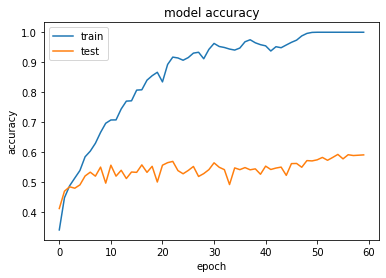

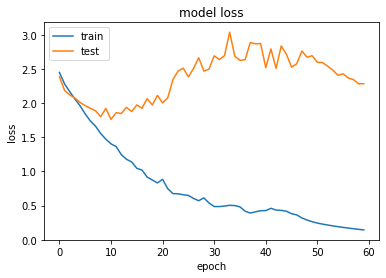

In [82]:
import matplotlib.pyplot as plt

history = hist
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model = wrn28_10

In [85]:
!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

     |████████████████████████████████| 87.9MB 128kB/s 
     |████████████████████████████████| 3.1MB 54.6MB/s 
     |████████████████████████████████| 501kB 51.8MB/s 
  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-t2zzybtm/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-t2zzybtm/cleverhans
     |████████████████████████████████| 163kB 6.9MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262572 sha256=6f8e154ebe9fc85137a5c34951913ff1b5ae80c1fcb418a277cb9360b60af393
  Stored in directory: /tmp/pip-ephem-wheel-cache-w1akdq_m/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans

Tensorflow Version: 2.2.0
Cleverhans Version: 3.0.1-fc7b7c7ec903258e0e3fb88503fa629f
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


In [0]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [0]:
epsilon = 0.05

adv_example_untargeted_label = fast_gradient_method(logits_model, image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

In [98]:
np.argmax(adv_example_untargeted_label_pred)

0